In [84]:
from whoosh.fields import Schema, ID, TEXT
from whoosh.analysis import StandardAnalyzer
from whoosh import index
from whoosh.index import create_in
from whoosh.qparser import MultifieldParser, OrGroup, FuzzyTermPlugin, QueryParser
import os.path
import shutil
import re
import timeit
import matplotlib.pyplot as plt
import numpy as np

In [85]:
schema = Schema(index=ID(stored=True),
                title=TEXT(stored=True),
                author=TEXT(stored=True),
                bibliography=TEXT(stored=True),
                body=TEXT(analyzer=StandardAnalyzer(stoplist=None)))

In [86]:
INDEX_DIRECTORY = "index_dir"
if not os.path.exists(INDEX_DIRECTORY):
    os.mkdir(INDEX_DIRECTORY)
ix = create_in(INDEX_DIRECTORY, schema)
ix = index.open_dir(INDEX_DIRECTORY)

In [87]:
class Text:

    def __init__(self, original):
        result = re.split(r'.T|.A|.B|.W', original.replace('\n', ' '))
        self.index, self.title, self.author, self.bibliography, self.body, *_ = result


class Query:

    def __init__(self, text):
        result = text.split('\n.W\n')
        self.index, self.body = map(lambda x: x.strip().replace('\n', ' '),
                                    result)

In [88]:
def parse_queries(filename):
    queries = []
    with open(filename, 'r') as file:
        txt = file.read()
        txt = txt.split('.I')[1:]
        queries = list(map(lambda x: Query(x), txt))
    return queries


def parse_text(filename):
    words = []
    with open(filename, 'r') as file:
        txt = file.read()
        txt = txt.split('.I')[1:]
        words = list(map(lambda x: Text(x), txt))
    return words


def get_ordered_relevant_searches(filename):
    query_relations = {}
    with open(filename, 'r') as file:
        txt = file.read()
        txt = txt.strip().split('\n')
        for i in txt:
            query, abstract, score = map(
                lambda x: int(x),
                filter(lambda x: len(x) > 0,
                       i.strip().split(' ')))
            if query - 1 not in query_relations:
                query_relations[query - 1] = [(abstract, score)]
            else:
                query_relations[query - 1].append((abstract, score))

    #ordenando as relations por rank
    for i in query_relations:
        query_relations[i].sort(key=lambda x: x[1])

    return query_relations


In [89]:
def search_results(parser, queries: list[Query], limits: list[int]):
    results_dict = {}
    with ix.searcher() as searcher:
        for i, (limit, query_to_parse) in enumerate(zip(limits, queries)):
            query = parser.parse(query_to_parse.body)
            results = searcher.search(query, limit=max(limit, 10))
            results_dict[i] = list(
                map(lambda x: (int(x.get('index')), x.score), results))
    return results_dict

In [90]:
def precision_at_k(answer, relevant, k=None):
    if k is None or k > len(answer) or k > len(relevant):
        k = min(len(answer), len(relevant))
    result = len(set(answer[:k]) & set(relevant)) / k if k != 0 else 0
    return result


def recall_at_k(answer, relevant, k=None):
    if k is None or k > len(answer) or k > len(relevant):
        k = min(len(answer), len(relevant))

    d = len(relevant)
    return len(set(answer[:k]) & set(relevant)) / d if d != 0 else 0

In [102]:
def all_results_by_func(answer_results_dict: dict,
                        relevant_results_dict: dict,
                        func,
                        k: int = None):
    size = len(relevant_results_dict)
    results = np.zeros(size)
    for i, (answer, relevant) in enumerate(
            zip(answer_results_dict.values(), relevant_results_dict.values())):
        answer = list(map(lambda x: x[0], answer))
        relevant = list(map(lambda x: x[0], relevant))
        results[i] = func(answer, relevant, k)
    return results


def plot_results(
        answer_results_dict,
        relevant_results_dict,
        func,
        k_s=range(1, 10 + 1),
        title: str = '',
):
    results = list(
        map(
            lambda k: all_results_by_func(
                answer_results_dict, relevant_results_dict, func, k).mean(),
            k_s))
    plt.plot(k_s, results, marker='o')
    plt.xlabel('K')
    plt.ylabel(f'{func.__name__} mean')
    plt.title(title)
    plt.show()

In [92]:
#OBTENDO QUERIES
queries = parse_queries('cran/cran.qry')

#OBTENDO PALAVRAS
words = parse_text('cran/cran.all.1400')

#OBTENDO BUSCAS RELEVANTES
relevant_dict = get_ordered_relevant_searches('cran/cranqrel')

In [93]:
#INDEXANDO RESULTADOS
t0 = timeit.default_timer()
writer = ix.writer()
error = False

for word in words:
    try:
        writer.add_document(index=f'{word.index}',
                            title=word.title,
                            author=word.author,
                            bibliography=word.bibliography,
                            body=word.body)
    except ValueError:
        error = True
        break

if error:
    writer.cancel()
else:
    writer.commit()

t1 = timeit.default_timer()
print(f'TEMPO DE INDEXAÇÃO = {(t1 - t0):.2f}s')

TEMPO DE INDEXAÇÃO = 1.89s


In [94]:
limits = list(map(lambda x: len(x), relevant_dict.values()))

In [95]:
#BUSCA 1: TITULO, AUTOR E CORPO
parser = MultifieldParser(fieldnames=["title", "author", "body"],
                          schema=schema,
                          group=OrGroup)
parser.add_plugin(FuzzyTermPlugin())

t0 = timeit.default_timer()
results_1 = search_results(parser, queries, limits)
t1 = timeit.default_timer()
print(f'TEMPO DA BUSCA 1 = {(t1 - t0):.2f}s')

TEMPO DA BUSCA 1 = 5.26s


In [96]:
#BUSCA 2: SOMENTE CORPO
parser_query = QueryParser("body", schema=schema, group=OrGroup)
parser_query.add_plugin(FuzzyTermPlugin())

t0 = timeit.default_timer()
results_2 = search_results(parser_query, queries, limits)
t1 = timeit.default_timer()
print(f'TEMPO DA BUSCA 2 = {(t1 - t0):.2f}s')

TEMPO DA BUSCA 2 = 4.64s


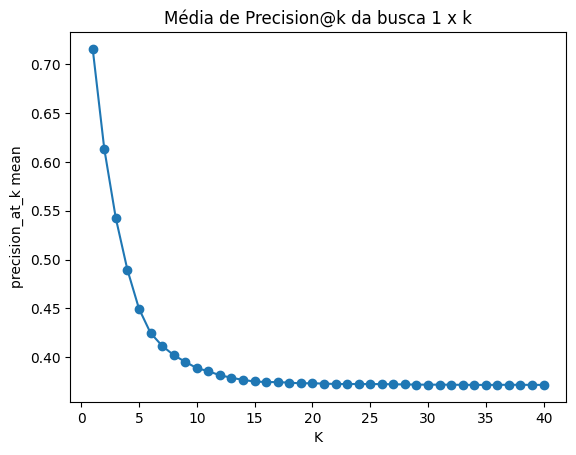

In [103]:
#PLOTANDO GRAFICO DE PRECISION DA BUSCA 1
plot_results(results_1,
             relevant_dict,
             precision_at_k,
             k_s=range(1, 41),
             title='Média de Precision@k da busca 1 x k (Whoosh)')

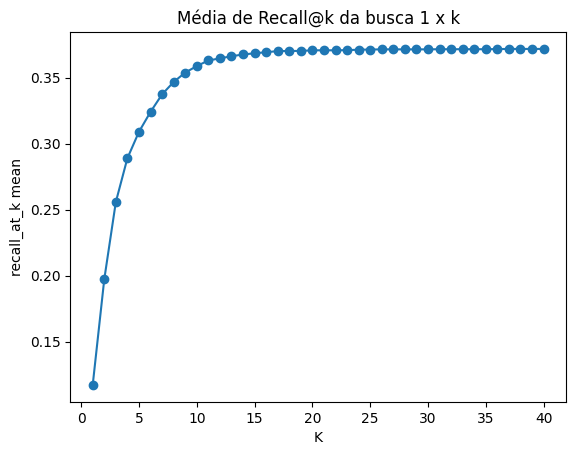

In [104]:
#PLOTANDO GRAFICO DE RECALL DA BUSCA 1
plot_results(results_1,
             relevant_dict,
             recall_at_k,
             k_s=range(1, 41),
             title='Média de Recall@k da busca 1 x k (Whoosh)')


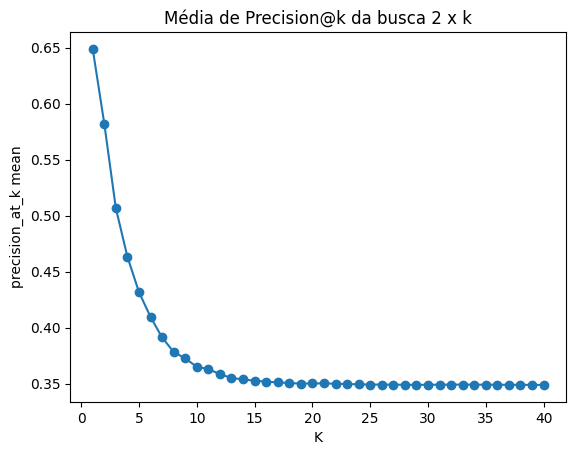

In [105]:
#PLOTANDO GRAFICO DE PRECISION DA BUSCA 2
plot_results(results_2,
             relevant_dict,
             precision_at_k,
             k_s=range(1, 41),
             title='Média de Precision@k da busca 2 x k (Whoosh)')

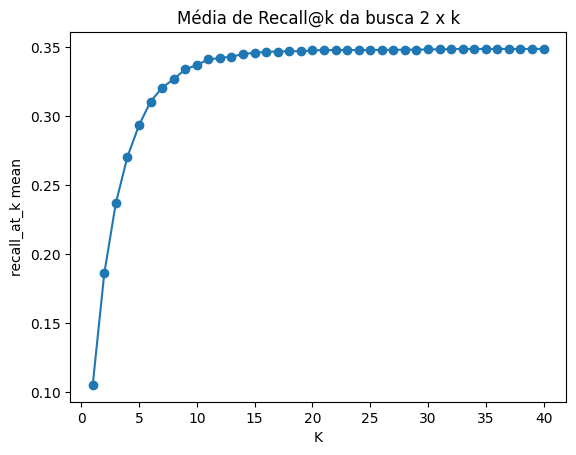

In [106]:
#PLOTANDO GRAFICO DE RECALL DA BUSCA 2]
plot_results(results_2,
             relevant_dict,
             recall_at_k,
             k_s=range(1, 41),
             title='Média de Recall@k da busca 2 x k (Whoosh)')

In [101]:
ix.close()
shutil.rmtree(INDEX_DIRECTORY)